# Logistic Regression
Binary or Multiclass <br>
This notebook will show how to build a logistic regression from scratch

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The logistic regression is essentially a ***softmax classifier***. <br>
We will inplement the model with the ***softmax function, MLE(or cross-entropy) and stocahstic gradient decent***.<br> We will also add the ***regularization*** on the model to solve the problem of redundant parameters.<br>
After the model is constructed, we will test the model on the iris data <br>
We will not build a class, but only a bunch of functions, which could be easily transformed to a logistic class.

Assume that we have labeled data X,y

In [2]:
# simulate the data for test
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([0, 4], [[1, .75],[.75, 1]], num_observations)

X = np.vstack((x1, x2)).astype(np.float32)
y = np.hstack((np.zeros(num_observations, dtype='int32'),
                              np.ones(num_observations, dtype='int32')))

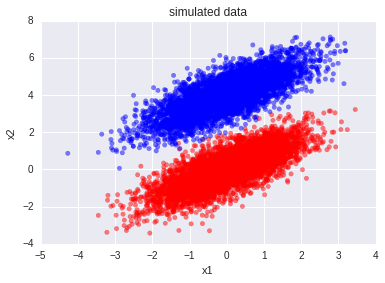

In [21]:
# visualize the simulation
colorPlate = {0:"red",1:"blue"}
colors = [colorPlate[c] for c in y]
plt.scatter(X[:,0], X[:,1], color = colors, alpha=0.5);
plt.title("simulated data");
plt.xlabel("x1");
plt.ylabel("x2");

Initialize the parameters

In [64]:
def init_params(X,y):
    # get number of classes
    Nclass = len(np.unique(y))
    Nfeature = X.shape[1]
    
    # initalize parameters
    # Weights for different classes
    W = np.random.randn(Nclass, Nfeature)

    # bias for different classes
    b = np.random.randn(Nclass)
    
    return W, b

In [65]:
np.random.seed(1212)
W, b = init_params(X,y)

In [66]:
def softmax(x):
    
    orig_shape = x.shape
    x = x - np.max(x)
    x = np.exp(x)/np.sum(np.exp(x))

    assert x.shape == orig_shape
    return x

We will write a function "softmaxGradient" to calculate the cost of one input and return the cost and gradient<br>
For each input, we can get the gradient for the W and b and update them during the iteration

In [67]:
def softmaxGradient(predictor, target, weights, bias, l = 1e-2):
    """
    predictor is one row of the data
    target is the corresponding label of classes
    W and b are weights and bias
    The regularization is also added to prevent redundant parameters
    """
    # get y_hat
    y_hat = softmax(np.dot(weights, predictor) + bias)

    # get cost
    cost = -np.log(y_hat[target]) + (l/2)*(np.sum(weights**2) + np.sum(bias**2))
    y_hat[target] -= 1

    # get grad with regularization
    gradW = np.outer(y_hat, predictor) + l*weights
    gradb = y_hat + l*bias
    return cost, gradW, gradb

In [68]:
# test
np.random.seed(4321)
cost, gradW, gradb = softmaxGradient(X[0,:], y[0], W, b)

In [69]:
print(cost, "\n" ,gradW, "\n", gradb)

0.135495931838 
 [[ 0.03014341  0.07104119]
 [-0.01814058 -0.08065607]] 
 [-0.10319659  0.1034958 ]


Then, we have to optimize the parameters. We will use the Stochastic gradient descent here<br>
The function will return the updated weights

In [70]:
def sgd(X, y, f, weights, bias, lr=1e-3, epochs=100, batchSize=10, PRINT_EVERY=100):
    Ndata = X.shape[0]
    index = np.array(range(Ndata)) 
    
    for i in range(epochs):
        
        # shuffle X and y
        expcost = None # cost accumulation
        np.random.shuffle(index) 
        X = X[index,:]
        y = y[index]
        
        XBatch = [X[k:k+batchSize,:] for k in np.arange(0, Ndata, batchSize)]
        yBatch = [y[k:k+batchSize] for k in np.arange(0, Ndata, batchSize)]
        gradWSum = np.zeros(weights.shape) # initialize the weights
        gradbSum = np.zeros(bias.shape) # initialize the bias
        
        for xb, yb in zip(XBatch, yBatch):
            bSize = len(yb)
            for j in range(bSize):
                cost, gradW, gradb = f(xb[j,:], yb[j], weights, bias) # calc gradients
                if expcost:
                    expcost += 0.05*cost
                else:
                    expcost = 0.05*cost
                assert gradW.shape == gradWSum.shape
                assert gradb.shape == gradbSum.shape
                gradWSum += gradW # accumulate batch gradient of W
                gradbSum += gradb # accumulate batch gradient of b
            weights -= lr * (1/bSize) * gradWSum # update W
            bias -= lr * (1/bSize) * gradbSum # update b
            
        if (i+1) % PRINT_EVERY == 0:
            print("Training cost after epoch {} is: {}".format(i+1, expcost))
        
    return weights, bias

In [71]:
np.random.seed(4321)
WNew, bNew = sgd(X, y, softmaxGradient, W, b, 1e-5, 700, 10, 1)

Training cost after epoch 1 is: 169.94332787084863
Training cost after epoch 2 is: 148.11343047524358
Training cost after epoch 3 is: 50.4222058781263
Training cost after epoch 4 is: 47.41990304210644
Training cost after epoch 5 is: 46.808131557846515
Training cost after epoch 6 is: 46.46194301895425
Training cost after epoch 7 is: 46.249156008410345
Training cost after epoch 8 is: 46.05530644104725
Training cost after epoch 9 is: 45.91511141943253
Training cost after epoch 10 is: 45.78182778289127
Training cost after epoch 11 is: 45.66510121137367
Training cost after epoch 12 is: 45.56465781370593
Training cost after epoch 13 is: 45.4706401155323
Training cost after epoch 14 is: 45.386987621109476
Training cost after epoch 15 is: 45.309453234368945
Training cost after epoch 16 is: 45.24704553374663
Training cost after epoch 17 is: 45.18323347505689
Training cost after epoch 18 is: 45.13318642740203
Training cost after epoch 19 is: 45.084229266812244
Training cost after epoch 20 is: 45

Then we use the logistic model to predict for the training data

In [74]:
def predict(X,W,b):
    return np.argmax(softmax(np.dot(X,W) + b.reshape(1,-1)))

In [75]:
pred_scratch = []
for i in range(len(y)):
    pred_scratch.append(predict(X[i,:], WNew, bNew))

print("training accuracy of model from scratch",sum(pred_scratch == y)/len(y))

training accuracy of model from scratch 0.9977


Compare with sklearn

In [42]:
from sklearn.linear_model import LogisticRegression

np.random.seed(4321)
logistic = LogisticRegression(penalty='l2', fit_intercept=True, C = 200, max_iter=700)
logistic.fit(X, y)

LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=700, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
pred_sk = logistic.predict(X)

print("training accuracy of model from scikit-learn",sum(pred_sk == y)/len(y))

training accuracy of model from scikit-learn 0.9993


Then we can visualize the boundary

In [16]:
WNew

array([[ 0.53802399, -0.85936368],
       [-0.53802399,  0.85936368]])

In [17]:
bNew

array([ 1.41689528, -1.41689528])

In [18]:
slope = WNew[1,0]/-WNew[1,1]
intercept = bNew[1]/-WNew[1,1]
abline_values = [slope * i + intercept for i in X[:,0]]

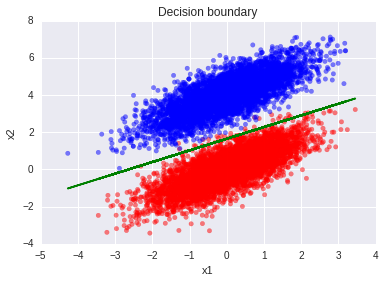

In [76]:
# visualize the simulation
colorPlate = {0:"red",1:"blue"}
colors = [colorPlate[c] for c in y]
plt.scatter(X[:,0], X[:,1], color = colors, alpha=0.5);
plt.plot(X[:,0], abline_values, 'g');
plt.title("Decision boundary");
plt.xlabel("x1");
plt.ylabel("x2");

Formular

$(-\infty, +\infty)$

$y^{}_{i} = \beta^{}_{0} +\beta^{}_{1} * x^{}_{i1} + ... ++\beta^{}_{p} * x^{}_{ip} + \epsilon,     i = 1,...,n$

$latex log(\frac{p^{}_{i}}{1-p^{}_{i}}) =\beta^{}_{0} +\beta^{}_{1} * x^{}_{i1} + ... +\beta^{}_{p} * x^{}_{ip} + \epsilon,     i = 1,...,n$